# A geocomputational to monitor regional development in Bolivia

## Setup

In [1]:
# Load libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd

import libpysal
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

import statsmodels.api as sm
import statsmodels.formula.api as smf

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.filterwarnings('ignore') 

/opt/conda/lib/python3.9/site-packages/esda/getisord.py:636: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if __name__ is "__main__":
/opt/conda/lib/python3.9/site-packages/spglm/utils.py:367: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if resetlist is not ():


## Import data

In [ ]:
dat = pd.read_stata("/work/project2021o/data/rawData/bd_atlasmunicipalodsbolivia2020_Stata15_full.dta")
dat

id          municipio     dep                    depmun  poly_id  \
0    80802             Baures    Beni               Beni-Baures      323   
1    80402         Exaltación    Beni           Beni-Exaltación      315   
2    80202       Guayaramerín    Beni         Beni-Guayaramerín      309   
3    80803          Huacaraje    Beni            Beni-Huacaraje      324   
4    80601             Loreto    Beni               Beni-Loreto      317   
..     ...                ...     ...                       ...      ...   
334  60401            Uriondo  Tarija            Tarija-Uriondo      245   
335  60501  Villa San Lorenzo  Tarija  Tarija-Villa San Lorenzo      247   
336  60303        Villamontes  Tarija        Tarija-Villamontes      244   
337  60301            Yacuiba  Tarija            Tarija-Yacuiba      242   
338  60402           Yunchará  Tarija           Tarija-Yunchará      246   

     asdf_id       imds  rank_imds  poblacion_2020  urbano_2012  sdg1_1_ee  \
0        295  51.000000        163            6247    35.700001        NaN   
1        218  44.099998        291            6607     0.000000        NaN   
2        226  53.099998        112           44446    85.599998  29.400000   
3         70  46.900002        257            4577    49.900002        NaN   
4         45  43.900002        294            4035     0.000000  57.000000   
..       ...        ...        ...             ...          ...        ...   
334       92  59.500000         30           15595     0.000000  39.099998   
335       97  59.500000         31           25796    14.300000  35.200001   
336       48  63.900002         16           51916    75.800003  19.700001   
337       94  62.500000         20          103723    69.599998  24.000000   
338       95  51.799999        145            5621     0.000000        NaN   

     sdg1_1_nbi  sdg1_2_pm  sdg1_4_ssb  sdg2_2_dm  sdg2_2_smu    sdg2_4_su  \
0     67.800003      0.205   24.600000  15.100000   32.099998   606.799988   
1     89.300003      0.371   27.100000  25.200001   20.100000  1480.699951   
2     38.200001      0.090   77.500000   9.200000   33.799999   114.599998   
3     77.500000      0.161   33.200001  15.100000   32.099998   967.099976   
4     81.500000      0.306   30.799999  25.200001   20.100000   678.099976   
..          ...        ...         ...        ...         ...          ...   
334   56.099998      0.097   47.900002  14.200000   27.500000     4.900000   
335   50.200001      0.107   55.299999  14.200000   27.500000     4.600000   
336   43.400002      0.055   75.000000  14.200000   27.500000   267.700012   
337   34.400002      0.045   80.699997  14.200000   27.500000    45.000000   
338   68.900002      0.136   55.200001  23.299999   26.000000     6.700000   

       sdg2_4_t   sdg3_1_p  sdg3_2_mi  sdg3_2_mn  sdg3_3_c  sdg3_3_d  \
0     46.400002  70.000000  20.299999  23.900000       0.0       0.0   
1     82.699997  59.000000  25.400000  33.900002       0.0       3.0   
2     16.200001  81.800003  19.900000  24.700001       0.0      10.8   
3     96.900002  69.800003  21.500000  25.799999       0.0       2.2   
4    103.000000  49.099998  31.200001  40.500000       0.0       0.0   
..          ...        ...        ...        ...       ...       ...   
334   90.699997  66.500000  16.299999  19.900000       0.2       0.0   
335   14.900000  61.700001  15.100000  18.200001       1.0       0.0   
336   49.099998  82.500000  17.400000  21.299999       3.2       1.8   
337   92.000000  80.300003  18.799999  23.200001       2.8       2.5   
338    2.900000  31.700001  21.299999  26.799999       0.6       0.0   

     sdg3_3_m    sdg3_3_t  sdg3_3_vih   sdg3_7_fa  sdg4_1_ash  sdg4_1_asm  \
0         1.7   32.200001         0.0  139.000000    2.300000         2.9   
1         0.0    0.000000         0.0  112.900002   13.900000         7.7   
2        37.5   72.800003       172.0  110.599998    9.500000         7.1   
3         0.0    0.000000         0.0  137.30000

In [ ]:
# Select key variables
df = dat[['asdf_id', 'imds']]
df.describe().round(2)

asdf_id    imds
count   339.00  339.00
mean    169.00   51.05
std      98.01    6.77
min       0.00   35.70
25%      84.50   47.00
50%     169.00   50.50
75%     253.50   54.85
max     338.00   80.20

In [ ]:
map = gpd.read_file("/work/project2021o/data/bolivia339_v20220404.geojson")

In [ ]:
map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
map.dtypes

POLY_ID        int64
asdf_id        int64
mun           object
mun_id         int64
dep           object
dep_id         int64
dep_mun       object
COORD_X      float64
COORD_Y      float64
geometry    geometry
dtype: object

In [ ]:
gdf = map.merge(df, on='asdf_id', how='left')
gdf

POLY_ID  asdf_id                    mun  mun_id         dep  dep_id  \
0          1      254                  Sucre   10101  Chuquisaca       2   
1          2      201                 Yotala   10102  Chuquisaca       2   
2          3      300                 Poroma   10103  Chuquisaca       2   
3          4      174                Azurduy   10201  Chuquisaca       2   
4          5      186                Tarvita   10202  Chuquisaca       2   
..       ...      ...                    ...     ...         ...     ...   
334      335      148             Santa Rosa   90401       Pando       6   
335      336      225                 Ingavi   90402       Pando       6   
336      337      229        Nueva Esperanza   90501       Pando       6   
337      338      227  Villa Nueva-Loma Alta   90502       Pando       6   
338      339      228         Santos Mercado   90503       Pando       6   

                         dep_mun    COORD_X    COORD_Y  \
0               Chuquisaca-Sucre -65.250484 -18.937735   
1              Chuquisaca-Yotala -65.264941 -19.225053   
2              Chuquisaca-Poroma -65.385167 -18.621706   
3             Chuquisaca-Azurduy -64.432897 -20.181367   
4             Chuquisaca-Tarvita -64.561802 -19.772150   
..                           ...        ...        ...   
334             Pando-Santa Rosa -67.278821 -10.731617   
335                 Pando-Ingavi -66.747376 -10.504600   
336        Pando-Nueva Esperanza -65.537806 -10.111327   
337  Pando-Villa Nueva-Loma Alta -66.105528 -10.650994   
338         Pando-Santos Mercado -66.136422 -10.153388   

                                              geometry       imds  
0    MULTIPOLYGON (((-65.05692 -18.67598, -65.06450...  69.599998  
1    MULTIPOLYGON (((-65.19584 -19.15171, -65.19605...  55.500000  
2    MULTIPOLYGON (((-65.34567 -18.41788, -65.34932...  35.700001  
3    MULTIPOLYGON (((-64.31034 -19.86033, -64.31317...  37.900002  
4    MULTIPOLYGON (((-64.42677 -19.60399, -64.42690...  40.000000  
..                                                 ...        ...  
334  MULTIPOLYGON (((-67.00163 -10.22934, -67.00676...  48.200001  
335  MULTIPOLYGON (((-66.59221 -9.90182, -66.59663 ...  43.599998  
336  MULTIPOLYGON (((-65.39100 -10.38122, -65.39188...  46.000000  
337  MULTIPOLYGON (((-65.73353 -10.70693, -65.71963...  43.000000  
338  MULTIPOLYGON (((-65.75154 -9.78151, -65.75576 ...  40.900002  

[339 rows x 11 columns]

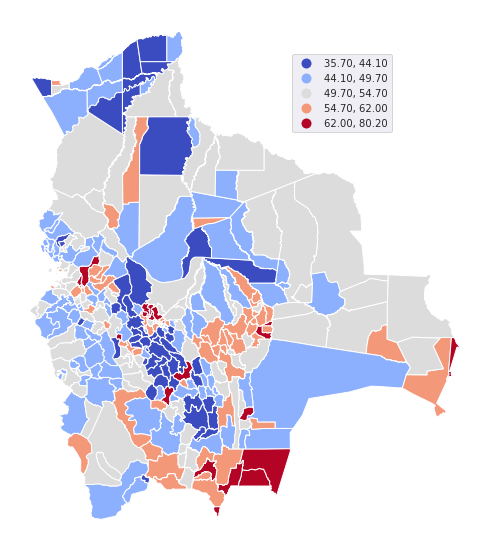

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
gdf.plot(column="imds", scheme='FisherJenks', k=5, cmap='coolwarm', legend=True, ax=ax, legend_kwds={'bbox_to_anchor':(0.82, 0.92)})
#plt.title('Spatial distribution of log GDP per capita in 1994: Five natural breaks')
plt.tight_layout()
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
gdf.explore(
    column = 'imds',
    tooltip = ['imds', 'dep_mun'],
    scheme = 'FisherJenks', # Quantiles, EqualInterval, BoxPlot, FisherJenks
    cmap = 'coolwarm', # hot, cividis, plasma, magma, inferno
    legend = True,
    tiles = 'Stamen Terrain',  # OpenStreetMap, Stamen Terrain, Stamen Toner, Stamen Watercolor, CartoDB positron, CartoDB dark_matter
    style_kwds  = dict(color="gray", weight=0.2),
    legend_kwds = dict(colorbar=False)
)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1c004d15-6318-43c0-9638-a2b00eb26b4d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>